# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 


## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [ ]:
!pip install -q tensorflow==2.3

In [ ]:
#аугментации изображений
!pip install albumentations -q

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [7]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [9]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [10]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [11]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [12]:
#Прологарифмируем целевую переменную price, чтобы сделать её распределение более походим на нормальное
train.price = train.price.apply(lambda x: np.log(np.log(x)))

In [ ]:
#Прологарифмируем числовые признаки
#train['mileage']=np.log(np.log(train['mileage']))


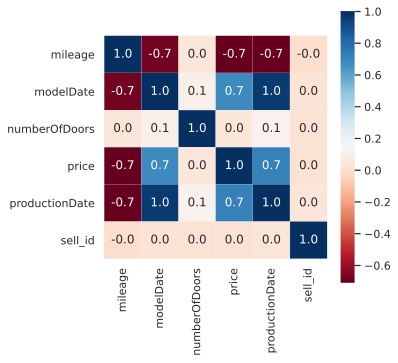

In [13]:
#Построим  корреляционную матрицу:
sns.set(font_scale=1)
plt.subplots(figsize=(5, 5))
sns.heatmap(train.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [14]:
train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [ ]:
#Преобразуем в числовые данные признак engineDisplacement:
#train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: '2.0 LTR' if x=='undefined LTR' else x)
#train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: float(x[0:3]))

In [ ]:
#Преобразуем в числовые данные признак enginePower:
#train['enginePower'] = train['enginePower'].apply(lambda x: int(x[:-4]))
#train['enginePower'] = np.log(np.log(train['enginePower']))

In [ ]:
#sns.set(font_scale=1)
#plt.subplots(figsize=(5, 5))
#sns.heatmap(train.corr(), square=True,
           #   annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [ ]:
#train.columns

In [ ]:
#def vladenie(x):
  #  if x=='1\xa0владелец':
  #     return 1
   # if x =='2\xa0владельца':
   #     return 2
   # if x =='3 или более':
    #    return 3

In [ ]:
#train.Владельцы = train.Владельцы.apply(vladenie)

In [ ]:
#train.Владельцы.value_counts()

In [ ]:
#sns.set(font_scale=1)
#plt.subplots(figsize=(5, 5))
#sns.heatmap(train.corr(), square=True,
          #    annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Посмотрим, как выглядят распределения числовых признаков:

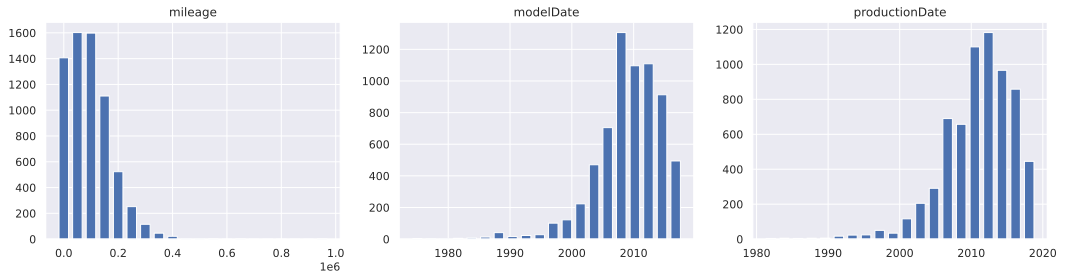

In [15]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [17]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль'] 

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate',
       'enginePower','engineDisplacement','productionDate', 'Владельцы'] 


In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


#  My Preproc

In [ ]:
#Прологарифмируем числовые признаки
data['mileage']=np.log(data['mileage'])

In [ ]:
#Преобразуем в числовые данные признак engineDisplacement:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x=='undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: float(x[0:3]))

In [ ]:
#Преобразуем в числовые данные признак enginePower:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4]))
data['enginePower'] = np.log(np.log(data['enginePower']))

In [ ]:
#Преобразуем признак владельцы в числовые данные:
def vladenie(x):
    if x=='1\xa0владелец':
        return 1
    if x =='2\xa0владельца':
        return 2
    if x =='3 или более':
        return 3

In [ ]:
data['Владельцы']=data['Владельцы'].apply(vladenie)

In [ ]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'modelDate': data['modelDate'].dropna(),
    'productionDate': data['productionDate'].dropna(),
    'engineDisplacement': np.log(data['engineDisplacement']).dropna(),
    'enginePower': data['enginePower'].dropna(),
    'Владельцы': data['Владельцы'].dropna()
})

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True) ####!!!
    
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
model = CatBoostRegressor(iterations = 7000,
                          depth=10,
                          learning_rate = 0.020953,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

In [ ]:
#Выполним предсказание модели catboost
test_predict_catboost = model.predict(X_test)

In [ ]:
#Возьмём обратную логарифму функцию - экспоненту (дважды), чтобы преобразовать тестовые данные в нормальный вид
abc = np.exp(np.exp(y_test))

In [ ]:
#Cделаем то же самое для предсказаний
abc2 = np.exp(np.exp(test_predict_catboost))

In [ ]:
abc2

In [ ]:
print(f"TEST mape: {(mape((abc), abc2))*100:0.2f}%")

In [ ]:
#logprice + logmileage = 11,65%
#loglogprice + logmileage + drop(modeldate) = 11,78%
#loglogprice TEST mape: 11.04% (с dropom vehicleConfiguration, а также logmileage, обработкой л.с., displaycement, Владельцы)
#loglogprice TEST mape: 11.02% (без дропа vehicleConfiguration)

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)


In [ ]:
sub_predict_catboost=np.exp(np.exp(sub_predict_catboost))

In [ ]:
sub_predict_catboost

In [ ]:
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

Для нейронных сетей не будем логарифмировать целевую переменную price, т.к. в результате эксперимента NN работает лучше без этого

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    #Прологарифмируем modelDate и productionDate для достижения более нормального распределения данных
    df_output = df_input.copy()
    df_output['modelDate'] = np.log(2030 - df_output['modelDate'])
    df_output['productionDate'] = np.log(2030 - df_output['productionDate'])
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True) ####!!!
    
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc_for_NN = preproc_data(data)
df_preproc_for_NN.sample(10)

In [ ]:
# Теперь выделим тестовую часть
train_data1 = df_preproc_for_NN.query('sample == 1').drop(['sample'], axis=1)
test_data1 = df_preproc_for_NN.query('sample == 0').drop(['sample'], axis=1)

y_1 = train_data1.price.values     # наш таргет
X_1 = train_data1.drop(['price'], axis=1)
X_sub1 = test_data1.drop(['price'], axis=1)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train1.shape[1], activation="relu")) #1024
model.add(L.Dropout(0.75)) #0.75
model.add(L.Dense(512, activation="relu")) #512
model.add(L.Dropout(0.6)) #0.6
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
#Возвратим целевые переменные в исходный вид
y_train1=np.exp(np.exp(y_train1))
y_test1=np.exp(np.exp(y_test1))

In [ ]:
history = model.fit(X_train1, y_train1,
                    batch_size=512, #512
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test1, y_test1),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test1)
print(f"TEST mape: {(mape((y_test1), test_predict_nn1[:,0]))*100:0.2f}%")

In [ ]:
#Посмотрим, какой mape даст сочетание catboost и nn1:
print(f"TEST mape: {(mape((y_test1), (test_predict_nn1[:,0]+abc2)/2))*100:0.2f}%")

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
sub_predict_nn1 = model.predict(X_sub1)

In [ ]:
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [ ]:
!pip install pymorphy2

In [ ]:
#Избавимся от лишних символов в описании методом ручного просмотра tokenize.word_index:
data.description = data.description.apply(lambda x: str(x).replace('[',' ').replace(']',' ').replace("'",' ').replace('•',' ').replace(',',' ').replace('―',' ').replace('–',' ').replace('«',' ').replace('»',' ').replace('✔',' ').replace('►',' ').replace('°',' ').replace('u',' ').replace('d',' ').replace('№',' ').replace('″',' ').replace('🏻',' ').replace('👮',' ').replace('♂️',' ').replace('❌',' ').replace('🤫','').replace('сыюъшаютър',' ').replace('твюь',' ').replace('яаш',' ').replace('ваюурэшш',' ').replace('ьхбвр',' ').replace('👋',' ').replace('👍',' ').replace('☝️',' ').replace('🔥',' ').replace('👋',' ').replace('💡',' ').replace('“',' ').replace('”',' ').replace('’',' ').replace('∙',' ').replace('\n',' ').replace('-',' ').replace('·',' ').replace('☛',' ').replace('₽',' ').replace('▼',' ').replace('f08',' ').replace('✪',' ').replace('✅',' ').replace('200b',' ').replace('☑️',' ').replace('…',' ').replace('。',' ').replace('⭐️',' ').replace('●',' ').replace('™',' ').replace('😉',' ').replace('☝',' ').replace('😅',' ').replace('▶',' ').replace('ö',' ').replace('🎁',' ').replace('😁',' ').replace('💁',' ').replace('🤷',' ').replace('☆',' ').replace('´',' ').replace('®️',' ').replace('❤️',' ').replace('²',' ').replace('202a',' ').replace('202c',' ').replace('😊',' ').replace('🎶',' ').replace('💆',' ').replace('♀️',' ').replace('🇯🇵',' ').replace('🍋',' ').replace('🤙',' ').replace('😇',' ').replace('º',' ').replace('🚘',' ').replace('✈️',' ').replace('🤗',' ').replace('®',' ').replace('❗',' ').replace('‼️',' ').replace('😀',' ').replace('ß',' ').replace('✌',' ').replace('🏽',' ').replace('😂',' ').replace('✨',' ').replace('🏼',' ').replace('👌',' ').replace('⬇️',' ').replace('💥',' ').replace('🧐',' ').replace('💪',' ').replace('。',' ').replace('😃',' ').replace('⚡',' ').replace('🚀',' ').replace('♠️',' ').replace('🎖️',' ').replace('💎',' ').replace('🔸',' ').replace('⭕️',' ').replace('🎯',' ').replace('🧟',' ').replace('😎',' ').replace('č',' ').replace('☎',' ').replace('⛽️',' ').replace('🙂',' ').replace('👺',' ').replace('✌️',' ').replace('🔝',' ').replace('😒',' ').replace('😉',' ').replace('🏆',' ').replace('🏝',' ').replace('🚨',' ').replace('🤛',' ').replace('👌',' ').replace('😁',' ').replace('🔕͟',' '))

In [ ]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+" #"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split(): 
        token = token.strip()
        token = morph.normal_forms(token)[0]
        if token and token not in stopwords_ru:
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None


### За счёт данной функции:
    1).избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов;
    2).разобьем пост на токены;
    3).проведем лемматизацияю, получив нормальную (начальную) форму слова;
    4).удалим стоп-слова.

In [ ]:
data.description = data.description.apply(lemmatize)

In [ ]:
#Возвратим формат данных обратно в строчное представление
data.description = data.description.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').replace('•','').replace(',',''))

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256 #256

In [ ]:
# split данных
text_train = data.description.iloc[X_train1.index]
text_test = data.description.iloc[X_test1.index]
text_sub = data.description.iloc[X_sub1.index]

In [ ]:
text_train[6323]

### Tokenizer

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
tokenize.word_index

In [ ]:
#Тот самый ручной перебор
for i in tokenize.word_index:
    print(i)

In [ ]:
len(tokenize.word_index)
#14250

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [ ]:
# вот так теперь выглядит наш текст
print(text_sub.iloc[1470])
print(text_train_sequences[6])

### RNN NLP

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1 , MAX_SEQUENCE_LENGTH,)) #len(tokenize.word_index)+1
model_nlp.add(L.LSTM (256, return_sequences=True)) #256
model_nlp.add(L.Dropout(0.5)) #0.5
model_nlp.add(L.LSTM (128,)) #LSTM  #128
model_nlp.add(L.Dropout(0.25)) #0.25
model_nlp.add(L.Dense(64, activation="relu")) #64
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train1.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
text_train_sequences

In [ ]:
history = model.fit([text_train_sequences, X_train1], y_train1, #text_train_sequences
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test1], y_test1), #text_test_sequences
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test1])
print(f"TEST mape: {(mape(y_test1, test_predict_nn2[:,0]))*100:0.2f}%") 

In [ ]:
#Посмотрим, какой mape даст сочетание catboost и nn2:
print(f"TEST mape: {(mape((y_test1), (test_predict_nn2[:,0]+abc2)/2))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub1])

In [ ]:
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train1.index)
images_test = get_image_array(X_test1.index)
images_sub = get_image_array(X_sub1.index)

### albumentations

Здесь я попробовал "подкрутить" все параметры аугментации в большую сторону

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.3),    #0.2
    OneOf([
        MotionBlur(p=0.3), #0.1
        MedianBlur(blur_limit=5, p=0.3), #3 , 0.1 
        Blur(blur_limit=5, p=0.3), #3 , 0.1
    ], p=0.3), #0.2
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.4, rotate_limit=25, p=3), #(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1)
    OneOf([
        OpticalDistortion(p=0.4), #0.3
        GridDistortion(p=0.2), #0.1
        IAAPiecewiseAffine(p=0.4),#0.3
    ], p=0.3), #0.2
    OneOf([
        CLAHE(clip_limit=5), #2
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.4), #0.3
    HueSaturationValue(p=0.4), #0.3
], p=3) #1

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train1, data.description.iloc[X_train1.index], y_train1  #текст x_train  data.description.iloc[X_train1.index]
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test1, data.description.iloc[X_test1.index], y_test1   # x_test вместо data.description data.description.iloc[X_test1.index]
    )).map(tf_process_val_dataset_element)

y_sub1 = np.zeros(len(X_sub1))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub1, data.description.iloc[X_sub1.index], y_sub1
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#Изменил модель на EfficientNetB4
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))#EfficientNetB3
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X_1.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=35, #100 Поменял в результате эксперимента количество эпох на наиболее оптимальное
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test1, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))

In [ ]:
sub_predict_nn3

In [ ]:
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (abc2 + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test1, blend_predict))*100:0.2f}%")

In [ ]:
#Округлил предсказание и привел его в надлежащий для демонстрации вид с помощью np.floor
blend_predict5 = np.floor((abc2 + test_predict_nn3[:,0]) / 2/10000)*10000
print(f"TEST mape: {(mape(y_test1, blend_predict5))*100:0.2f}%")

In [ ]:
blend_predict5

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [ ]:
blend_sub_predictt = np.floor((sub_predict_catboost + sub_predict_nn3[:,0]) / 2/10000)*10000
sample_submission['price'] = blend_sub_predictt
sample_submission.to_csv('blend_submissionn.csv', index=False)

# Model Bonus: проброс признака (в своей работе не использовал)

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
# 